In [8]:
import pickle
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [20, 20]
import random
import sys
import seaborn as sns
import pandas as pd
from scipy import stats
import os
from sklearn.mixture import GaussianMixture
import math

In [2]:
def get_data_in_dataframe(function_to_ages,ages_list):
    data = [] #function, ages_list, mean, std, len, rand_mean, rand_std
    for func in function_to_ages:
        curr = []
        ages = np.array(function_to_ages[func])
        
        #remove Nones
        ages = ages[ages != np.array(None)]
        if len(ages) == 0:
            continue
            
        #calculation of stats
        curr.append(func)
        curr.append(ages)
        curr.append(np.mean(ages))
        curr.append(np.std(ages))
        curr.append(len(ages))
        
        g = GaussianMixture(2)
        covs = g.fit(ages.reshape(-1,1)).covariances_
        std1 = math.sqrt(covs[0][0][0])
        std2 = math.sqrt(covs[1][0][0])
        curr.append(std1)
        curr.append(std2)
        curr.append((std1+std2)/2.0)
            
        #random (based on num ages)
        rand_ages = np.array(random.sample(ages_list,len(ages)))
        curr.append(np.mean(rand_ages))
        curr.append(np.std(rand_ages))
        g = GaussianMixture(2)
        covs = g.fit(rand_ages.reshape(-1,1)).covariances_
        std1 = math.sqrt(covs[0][0][0])
        std2 = math.sqrt(covs[1][0][0])
        curr.append(std1)
        curr.append(std2)
        curr.append((std1+std2)/2.0)
        data.append(curr)
        
    df = pd.DataFrame(data)
    df.columns = ['function_name','ages_list',
                  'age_mean','age_std','num_els',
                  'age_gmm2_std1', 'age_gmm2_std2','age_gmm2_std_avg',
                  'rand_age_mean','rand_age_std', 'rand_age_gmm2_std_avg',
                  'rand_age_gmm2_std1','rand_age_gmm2_std2']
    return df

In [3]:
def violin(ax,df,col1,col2,label=None): #grouped by size
    if label == None:
        label = col1
    len_list = df['num_els'].tolist()
    std_list = df[col1].tolist()
    rand_std_list = df[col2].tolist()
    
    lq = np.percentile(len_list,25)
    mq = np.percentile(len_list,50)
    uq = np.percentile(len_list,75)  
    
    len_dict_func_std_list = {}
    len_dict_rand_std_list = {}

    for i in range(0,len(std_list)):
        l = len_list[i]
        if l not in len_dict_func_std_list:
            len_dict_func_std_list[l] = []
            len_dict_rand_std_list[l] = []
        len_dict_func_std_list[l].append(std_list[i])
        len_dict_rand_std_list[l].append(rand_std_list[i])

    len_func_stds = []
    len_rand_stds = []
    len_order_list = []
    for l in len_dict_func_std_list:
        len_func_stds.append(np.mean(len_dict_func_std_list[l]))
        len_rand_stds.append(np.mean(len_dict_rand_std_list[l]))
        len_order_list.append(l)
    
    
    v_data = []
    for l in len_dict_func_std_list:
        if l < lq:
            for s in len_dict_func_std_list[l]:
                v_data.append(["<%d"%lq,s,"Func"])
            for s in len_dict_rand_std_list[l]:
                v_data.append(["<%d"%lq,s,"Rand"])
        elif l < mq:
            for s in len_dict_func_std_list[l]:
                v_data.append(["<%d"%mq,s,"Func"])
            for s in len_dict_rand_std_list[l]:
                v_data.append(["<%d"%mq,s,"Rand"])
        elif l < uq:
            for s in len_dict_func_std_list[l]:
                v_data.append(["<%d"%uq,s,"Func"])
            for s in len_dict_rand_std_list[l]:
                v_data.append(["<%d"%uq,s,"Rand"])
        else:
            for s in len_dict_func_std_list[l]:
                v_data.append(["Largest",s,"Func"])
            for s in len_dict_rand_std_list[l]:
                v_data.append(["Largest",s,"Rand"])

    
    v_df = pd.DataFrame(v_data,columns = ["GeneSet",label,"Type"])
    sns.violinplot(x="GeneSet",y=label,data=v_df,ax=ax, order = ["<%d"%lq,"<%d"%mq ,"<%d"%uq,"Largest"],hue="Type",palette="muted",split=True,legend=False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, rotation_mode="anchor")
    

    print ("<%d"%lq, stats.wilcoxon(v_df[v_df['Type']=="Func"][v_df["GeneSet"] == "<%d"%lq][label], v_df[v_df['Type']=="Rand"][v_df["GeneSet"] == "<%d"%lq][label]))
    print ("<%d"%mq, stats.wilcoxon(v_df[v_df['Type']=="Func"][v_df["GeneSet"] == "<%d"%mq][label], v_df[v_df['Type']=="Rand"][v_df["GeneSet"] == "<%d"%mq][label]))
    print ("<%d"%uq, stats.wilcoxon(v_df[v_df['Type']=="Func"][v_df["GeneSet"] == "<%d"%uq][label], v_df[v_df['Type']=="Rand"][v_df["GeneSet"] == "<%d"%uq][label]))
    print ("Largest", stats.wilcoxon(v_df[v_df['Type']=="Func"][v_df["GeneSet"] == "Largest"][label], v_df[v_df['Type']=="Rand"][v_df["GeneSet"] == "Largest"][label]))
    

In [4]:
# GET FUNC GROUPED AGE DATA
function_to_ages = pickle.load(open("data/function_to_age_simplified_dict.p","rb"))

gene_to_age_dict = pickle.load(open("data/gene_to_age_simplified_dict.p","rb"))
ages_list = []
for gene in gene_to_age_dict:
    ages_list.append(gene_to_age_dict[gene])
    
df = get_data_in_dataframe(function_to_ages,ages_list)

/home/angel/.local/lib/python3.5/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/angel/.local/lib/python3.5/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/angel/.local/lib/python3.5/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/angel/.local/lib/python3.5/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/angel/.local/lib/python3.5/site-packages/sklearn/cluster/k_means_.py:972: Converge

/home/angel/.local/lib/python3.5/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/angel/.local/lib/python3.5/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/angel/.local/lib/python3.5/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/angel/.local/lib/python3.5/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/angel/.local/lib/python3.5/site-packages/sklearn/cluster/k_means_.py:972: Converge

In [5]:
df

,function_name,ages_list,age_mean,age_std,num_els,age_gmm2_std1,age_gmm2_std2,age_gmm2_std_avg,rand_age_mean,rand_age_std,rand_age_gmm2_std_avg,rand_age_gmm2_std1,rand_age_gmm2_std2
0,GO:0006024~glycosaminoglycan biosynthetic process,"[0.5, 0.3333333333333333, 0.3333333333333333, ...",0.440847,0.243103,15,0.192219,0.043095,0.117657,0.755556,0.334313,0.305452,0.001000,0.153226
1,hsa04024:cAMP signaling pathway,"[1.0, 0.3333333333333333, 0.5555555555555556, ...",0.593735,0.315639,135,0.204230,0.209826,0.207028,0.514754,0.339523,0.185379,0.206812,0.196096
2,SM00049:DEP,"[0.6666666666666666, 0.0, 0.2, 0.6666666666666...",0.466667,0.301386,8,0.095669,0.196698,0.146183,0.362202,0.322301,0.129477,0.245644,0.187561
3,GO:0071556~integral component of lumenal side ...,"[1.0, 1.0, 0.3333333333333333, 0.0, 1.0, 1.0, ...",0.741026,0.378516,13,0.001000,0.305968,0.153484,0.335836,0.261240,0.211699,0.001000,0.106350
4,GO:0015293~symporter activity,"[1.0, 1.0, 0.125, 0.5714285714285714, 0.8, 0.5...",0.576354,0.274702,17,0.130272,0.208433,0.169353,0.632582,0.381429,0.201247,0.061388,0.131317
5,domain:SH3 1,"[0.5, 1.0, 0.3333333333333333, 0.4, 0.85714285...",0.671875,0.240371,11,0.145934,0.064409,0.105172,0.541047,0.306567,0.157924,0.095730,0.126827
6,GO:0015015~heparan sulfate proteoglycan biosyn...,"[0.25, 0.3333333333333333, 0.0, 0.0]",0.145833,0.148780,4,0.041679,0.001000,0.021339,0.525000,0.476314,0.001000,0.050010,0.025505
7,short sequence motif:Prevents secretion from ER,"[0.0, 0.14285714285714285, 0.25, 1.0, 0.25, 0....",0.410272,0.389311,16,0.142516,0.088870,0.115693,0.644147,0.381669,0.168692,0.061855,0.115273
8,GO:0019532~oxalate transport,"[0.75, 0.75, 0.75, 0.7142857142857143, 0.75]",0.742857,0.014286,5,0.001000,0.001000,0.001000,0.519481,0.418980,0.001000,0.189790,0.095395
9,GO:0043560~insulin receptor substrate binding,"[1.0, 0.9090909090909091, 0.5, 0.25, 0.5, 1.0]",0.693182,0.290385,6,0.042865,0.117910,0.080388,0.342593,0.377365,0.223801,0.001000,0.112400


/home/angel/.local/lib/python3.5/site-packages/ipykernel_launcher.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/angel/.local/lib/python3.5/site-packages/ipykernel_launcher.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/angel/.local/lib/python3.5/site-packages/ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/angel/.local/lib/python3.5/site-packages/ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/angel/.local/lib/python3.5/site-packages/ipykernel_launcher.py:63: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/angel/.local/lib/python3.5/site-packages/ipykernel_launcher.py:63: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/angel/.local/lib/python3.5/site-packages/ipykernel_launcher.py:64: UserWarning: Boolean Series key w

<6 WilcoxonResult(statistic=26008.0, pvalue=1.1309344360841863e-28)
<10 WilcoxonResult(statistic=36481.0, pvalue=1.1363533864145643e-37)
<25 WilcoxonResult(statistic=55677.0, pvalue=6.143896400363114e-20)
Largest WilcoxonResult(statistic=56879.0, pvalue=3.5986576337623586e-14)


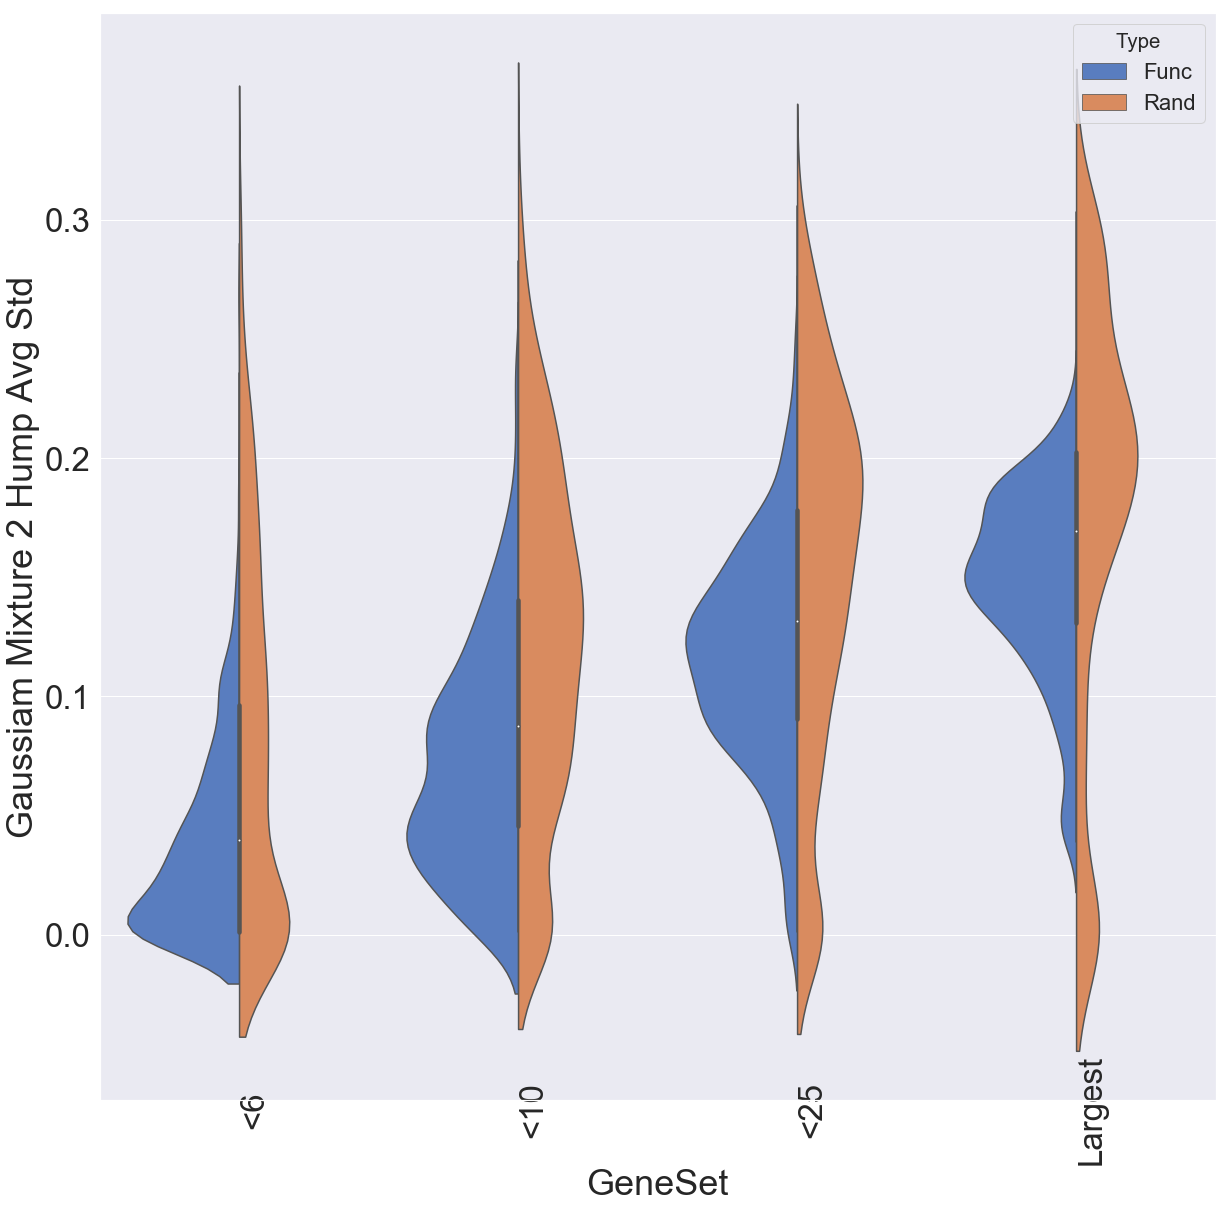

In [14]:
fig, ax = plt.subplots(1, 1 , sharex=False, sharey=False)
sns.set(font_scale=2)
violin(ax ,df,'age_gmm2_std_avg','rand_age_gmm2_std_avg','Gaussiam Mixture 2 Hump Avg Std')